# Deep Neural Network for Digit Classification

# 1 - Packages

Let's first import all the packages that I'll be using during this project.

* numpy is the main package for scientific computing with Python.
* pandas is a library for data manipulation and analysis.
* matplotlib is a library to plot graphs in Python.
* math contains some useful mathematical functions.
* train_test_split is used to split our training data into training, dev datasets.

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

# 2 - Dataset

*  We imported the train, test data provided by MNIST.
* We then splitted the train data into two datasets, one contained features and other contained the target variables.
* We then splitted the features, targets into training, dev sets with 1/9 ratio.

In [78]:
train = pd.read_csv("../input/train.csv")           #Import the data
X_test_orig = pd.read_csv("../input/test.csv")

features = train.drop("label", axis=1)              #Split the data into features and target.
target = np.array(train['label'])

X_train_orig, X_dev_orig, y_train, y_dev = train_test_split(features, target, test_size=0.1, random_state=42)    #Split the data into train, dev sets.

del train
del features
del target

# 3 - Visualization

Now we are going to check some pictures from our training data to see what do they actually contain. Here we plotted 25 pictures in a 5x5 grid.

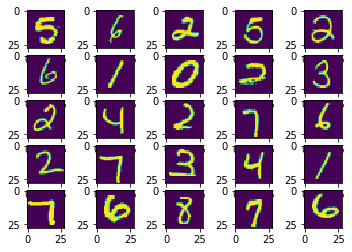

In [79]:
f, ax = plt.subplots(5, 5)
for i in range(1,26):
    grid=X_train_orig.values.reshape(-1,28,28,1)[i][:, :, 0]
    n=math.ceil(i/5)-1
    m=[0,1,2,3,4]*5
    ax[m[i-1], n].imshow(grid)

# 4 - Data Pre-processiong

* Here we normalized our data from the range of 0 - 255 to the range of 0 - 1.
* Then we converted our train, dev target sets to One-hot vectors.
* Then we shaped our data sets to fit to our NN model.

In [80]:
X_train = X_train_orig / 255.0                               #Normalization of datasets.
X_test = X_test_orig / 255.0

m = y_train.shape[0]                                    #Conversion to one hot vectors.
Y_train = np.zeros((m, 10))
Y_train[np.arange(m), y_train] = 1

n = y_dev.shape[0]
Y_dev = np.zeros((n, 10))
Y_dev[np.arange(n), y_dev] = 1

X_train = X_train.T                                     #Reshaping the datasets.
Y_train = Y_train.T
X_dev = X_dev.T
Y_dev = Y_dev.T
X_test = X_test.T

print ("train_x's shape: " + str(X_train.shape))        #Printing the shapes to check whether everythings on place or not.
print ("train_y's shape: " + str(Y_train.shape))
print ("dev_x's shape: " + str(X_dev.shape))
print ("dev_y's shape: " + str(Y_dev.shape))
print ("test_x's shape: " + str(X_test.shape))

train_x's shape: (784, 37800)
train_y's shape: (10, 37800)
dev_x's shape: (784, 4200)
dev_y's shape: (10, 4200)
test_x's shape: (784, 28000)


# 5 - Architecture of our model

Now that we are familiar with the dataset, it is time to build a deep neural network to distinguish between different digit images.

*  layer_dims defines how many layers our model is gonna have and how many nodes each one of them will contain.

I tried a bunch of different architectures but this one worked the best for me as increasing the number of layers caused varience and so many nodes in a single layer leades to more computation time.

In [81]:
# Constants which defines the model.
layer_dims = (X_train.shape[0], 500, 10)

# 6 - Initialization

This function is responsible for initialization of weights and biases. This function can initialize parameters for any deep NN architecture as it isn't hardcoded to work with a specific model.

In [82]:
def initialize_parameters(layers_dims):
    
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

**Helper functions**

These functions handels some basic calculation tasks which are importand in forward and backward propagation.
*  sigmoid, relu - As the name suggests these functions calculate the Sigmoid, Relu of a value respectively.
* sigmoid_backward, relu_backward - These functions are used in back propagation as they calculates dZ from dA(derivative of the activation of the previous layer). 

If A = Sigmoid(Z) then we'll use sigmoid _backward to calculate dZ otherwise we'll use relu_backward.

In [83]:
def sigmoid(Z):                             #This function calculates the sigmoid of z
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):                                #This function calculates the relu of z
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

In [84]:
def sigmoid_backward(dA, cache):            #These functions calculates dZ from dA.
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

# 7 - Forward propagation modules

In forward propagation our model has to perform 4 tasks - 

**7 . 1 - Calculate the linear function. **

z = Weights * Activation_of_previous_layer + bias

**7 . 2 - Calculate the activation function.**

a = activation(z)     

In this model we are using linear --> relu --> linear --> relu --- (for all the hidden layers) ---> linear --> sigmoid

**7 . 3 - Propagate forward.**

Once we have calculated the activations for one layer then we have to hop on to next layer to calculate it's activations, this is called forward propagation. We do this for all the layers in our model.

**7 . 4 - Compute the cost.**

This function signifies the gap between the values predicted and the actual values. We are to make this gap as narrow as possible which means we have to minimize the cost function. And for this purpose we optimize our parameters.

The above tasks are divided between 3 functions-
* forward_activation calculates the linear, activation functions.
* forward_propagation uses forward_activation to calculate the activations for the entire network as it propagates from layer L to L+1.
* compute_cost function calculates the cost at the end of forward propagation.

In [85]:
def forward_activation(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b                         #Calculate the linear function.
    linear_cache = (A_prev, W, b)                     #Store the linear_cache.
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)              #Calculate the sigmoid of Z.
    
    elif activation == "relu":
        A, activation_cache = relu(Z)                 #Calculate the relu of Z.
    
    cache = (linear_cache, activation_cache)          #store both the caches into cache.
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    assert (A.shape == (W.shape[0], A_prev.shape[1]))

    return A, cache

In [86]:
def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_activation(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')
        caches.append(cache)
    
    AL, cache = forward_activation(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (10,X.shape[1]))
            
    return AL, caches

In [87]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))      #Calculate the cost.
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect.
    assert(cost.shape == ())
    
    return cost

# 8 - Backward propagation modules

In backward propagation our model has to complete 2 tasks-

**8 . 1 - Calculate the gradients.**

Calculate the values of dZ, dW, dc using dA of next layer and parameters of the current layer.

**8 . 2 - Propagate backwards.**

Once we've computed the grads of one layer then we go to the layer before that. We do this for every layer except the input layer.

**backward_activation**

This function calculates the gradients.

In [88]:
def backward_activation(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    
    #dA_prev, dW, db = linear_backward(dZ, linear_cache)
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m    
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

**back_propagate**

This function uses backward_activation to calculate the gradients of one layer and then jumps from layer L to L - 1 to compute it's gradients.

In [89]:
def back_propagation(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward_activation(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

# 9 - Optimization

This section is used to optimize the weights and biases. 

In this model I used gradient descent algorithm for optimization purposes.

In [90]:
def optimize(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate * grads['db' + str(l + 1)]
        
    return parameters

# 10 - L layer neural network

Finally.. Finally.. Finally.. This is the time to sum it all up and use all of our previous functions to create a fully fledged Neural Network.

In [91]:
def model(X, Y, layer_dims, learning_rate=0.4, num_iterations=3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters(layer_dims)            #Initialize the parameters for our model.
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = forward_propagation(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = back_propagation(AL, Y, caches)
        
        # Gradient descent
        parameters = optimize(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters


# Train the model

As our model is now ready we can start it's training.

Here I specified the number of iterations to 1000 because the cost was minimizing with insignificant values after that.

Cost after iteration 0: 6.920515
Cost after iteration 100: 0.659092
Cost after iteration 200: 0.482869
Cost after iteration 300: 0.397061
Cost after iteration 400: 0.341135
Cost after iteration 500: 0.300116
Cost after iteration 600: 0.268134
Cost after iteration 700: 0.242165
Cost after iteration 800: 0.220619
Cost after iteration 900: 0.202388


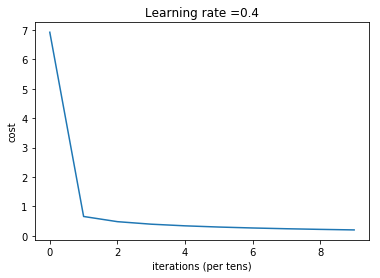

In [92]:
parameters = model(X_train, Y_train, layer_dims, num_iterations=1000, print_cost=True)

The plot above shows how the cost varies with the number of iterations and up until ~100 it has got a steep slope and after that point it barely minimizes throughout the plot.

# Make the predictions

Now that our model is trained, we can now see how well does our model do with training, test data.

In [93]:
def predict(X, parameters):
    
    m = X.shape[1]
    # Forward propagation
    probas, caches = forward_propagation(X, parameters)
    
    p = np.reshape(np.argmax(probas, axis=0), (1, m))
    
    return p

In [94]:
def accuracy(p, y):
    m = p.shape[1]
    s = 0
    y = np.reshape(np.argmax(y, axis=0), (1, m))
    for i in range(m-1):
        if np.array_equal(p[0, i], y[0, i]):
            s = s + 1
    acc = round((s/m) * 100, 2)
    return acc

**Testing our model's performance on the training set**

If the model doesn't do good on training data then our model would suffer through high bias which means our model is underfitting the data. In that case increasing the number of layers should do the trick.

In [95]:
pred_train = predict(X_train, parameters)
print('training accuracy is: {}'.format(accuracy(pred_train, Y_train)))

training accuracy is: 97.7


**Testing our model's performance on the dev set**

If the model does surprisingly well on training data but performs poorly on test data then our model would suffer through high variance problem which means our model is overfitting the data. In that case I'd try gathering more data or redesign my model's architecture.

In [96]:
pred_dev = predict(X_dev, parameters)
print('test accuracy is: {}'.format(accuracy(pred_dev, Y_dev)))

test accuracy is: 95.6


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


**Check the predections on the images in the test set**

As we haven't used the test set we got in our model until now. Now let's see how our model is working on these images.

Here You can change the index value to see the predictions on different images.

prediction is: 7


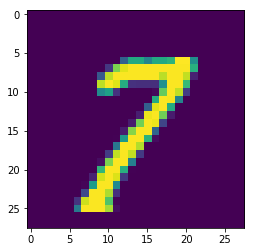

In [97]:
index = 6969
plt.imshow(X_test_orig.values.reshape(-1,28,28,1)[index][:, :, 0])
prediction = np.squeeze(predict(np.reshape(X_test.values[:, index], (X_test.shape[0], 1)), parameters))
print('prediction is: {}'.format(prediction))

**Output the submission file**

In [98]:
# predict results
results = (predict(X_test, parameters))
with open('submission.csv', 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(results)) :
        f.write("".join([str(i+1),',',str(results[i]),'\n']))

# Conclusion

* In this project I learned how to handel the image datasets and how to perform multiclass classification for cases like this.

* In this project I learned how to handel high bias and high variance as at first I got 86% train 78% test accuracy which was pretty pathetic. Then I tweaked the architecture on model a bit, also tweaked some hyperparameters to get this 96% accuracy on test set.